# Drill

In this experiment, we will tinker with ways we can cluster or group paragraphs by similarity. We will see how changing different parameters and features change the similarity of our sentence groups.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy

import nltk
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load('en')

Import the data in the form of paragraphs. <br>
To clean, remove double-dash from all words (spaCy does not recognize). <br>
(We will actually be using the first sentence per paragraph to cut down our processing time.) <br>
Form each paragraph into a string and add it to the list of strings.

In [2]:
emma=gutenberg.paras('austen-emma.txt')

emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    para=[re.sub(r'--','',word) for word in para]
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


Let's implement the sklean tfidf function. We will be doing dimension reduction later, so let's keep all the words for now. <br>

max_df: drops all words that have a document frequency higher than this specific threshold.<br>
min_df: uses all words that appear at least that many times <br>
stop_words: defines the dictionary of stop words to pull from <br>
lowercase: converts all words to lowercase since Alice in Wonderland has a habit of capitalizing <br>
use_idf: use inverse document frequencies in the weighting <br>
norm: (u'l2') applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally <br>
smooth_idf: adds 1 to all document frequencies to prevent divide-by-zero errors <br><br>

Apply the vectorizer to create new vectorized dataframe. <br>
Split into training and testing sets. <br>
Convert to csr to reshape the vectorizer output into something people can read. <br><br>

Define n as the number of paragraphs (number of rows in the dataframe). <br>
Create a list of dictionaries; one dictionary per paragraph. <br>
Define terms as the list of features using sklearn built-in feature get_feature_names(). <br>
For each paragraph, list the feature words and their tf-idf scores. Calling .nonzero() returns a tuple of arrays, one for each dimension of a, containing the indices of the non-zero elements in that dimension. Because so many of the values are 0, we don't need to waste space creating a dataframe of mostly 0's. This returns the positions of the non-zero values.<br>
Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.


In [3]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])
print('emma_paras_tfidf')
print(emma_paras_tfidf)

X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()
print('emma_paras_csr')
print(X_train_tfidf_csr)

n = X_train_tfidf_csr.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
emma_paras_tfidf
  (0, 561)	0.526920649962
  (0, 959)	0.849914483136
  (1, 1859)	1.0
  (2, 274)	1.0
  (3, 561)	0.0981254774043
  (3, 1914)	0.151764777883
  (3, 807)	0.23491932626
  (3, 307)	0.23491932626
  (3, 1474)	0.272205137645
  (3, 323)	0.226030521534
  (3, 853)	0.192257673953
  (3, 816)	0.18642581838
  (3, 504)	0.238432290064
  (3, 1815)	0.282808587453
  (3, 199)	0.211085798403
  (3, 205)	0.282808587453
  (3, 624)	0.282808587453
  (3, 1038)	0.263980463003
  (3, 1157)	0.246656964706
  (3, 1941)	0.218874275973
  (3, 1918)	0.20773274037
  (3, 1037)	0.151764777883
  (3, 511)	0.272205137645
  (4, 1946)	0.331370087052
  (4, 433)	0.318945902492
  :	:
  (2368, 857)	0.161541253151
  (2368, 241)	0.206332022994
  (2368, 691)	0.248482533856
  (2368, 1483)	0.225160877248
  (2368, 961)	0.217652980766
  (2368, 1131)	0.240974637375
  (2368, 374)	0.248482533856
  (2368, 1319)	0.258161895894
  (2369, 1037)	0.163664149393
  (2369, 1142)	0.131642037081
  (2369, 879)	0.249880

# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph. It's time to do some dimension reduction. We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity). <br>
Reduce the feature space from 1379 to 130. <br>
Run SVD on the training data then project. <br>
Look at what sorts of paragraphs (sentences) our solution considers similar, for the first five identified topics.

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.20116821
Component 0:
" Oh !"    0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !"    0.999292
" Oh !     0.999292
" Oh !"    0.999292
" Oh !     0.999292
" Oh !     0.999292
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634400
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.590476
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.567739
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think

From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma. What fun!

# Sentence similarity

We can also look at how similar various sentences are to one another. For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set: <br>

Compute document similarity using LSA components. <br>
Filter down to only first 10 sentences. <br>
Make a heat map and generate a key. <br>

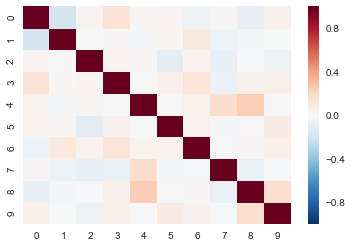

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [5]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

Not much similarity at all except between sentences 8 and 9, both of which seem to describe people getting along well.

# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?

In [6]:
X_train_lsa = lsa.fit(X_train_tfidf)
X_test_pred = X_train_lsa.transform(X_test_tfidf)

paras_by_component=pd.DataFrame(X_test_pred,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.674153
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wanting _him_ to dance with Mrs . Elton himself , and

Yes, this model identifies similar sentences for components 0 through 4. Component 0 is all exclamations including "Oh!" Component 1 is all dialogue involving Mr.'s and Mrs.'s from Emmas circle of acquaintances. Component 2 is all chapter titles. Component 3 is all exclamations including "Ah!" Component 4 is all short dialogue directed at or coming from Emma, usually with a slight negative tone. 

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

First, I want to add spaCy information on lemmas to simplify the sentences.

In [7]:
spacy_paras = []

for para in emma_paras:
    spacy_paras.append(nlp(para))

lemma_paras = []
for para in spacy_paras:
    lemma_para = [token.lemma_
                  for token in para
                  if (
                      not token.is_punct
                      and not token.is_stop
                  )]
    lemma_para = ' '.join(lemma_para)
    lemma_paras.append(lemma_para)

print(emma_paras[:10])    
print(lemma_paras[:10])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .', "She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period .", "Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma .", "The real evils , indeed , of Emma ' s situation were the power of having rather too much her own way , and a disposition to think a little too well of herself ; these were the disadvantages which threatened alloy to her many enjoyments .", 'Sorrow came  a gentle sorrow  but not at all in the shape of any disagreeable consciousne

Now I want to use the same parameters as earlier but test them on the lemma-updated dataset.

In [8]:
def change_vectorizer (df, maxdf, mindf):

    vectorizer = TfidfVectorizer(max_df=maxdf,
                                 min_df=mindf,
                                 stop_words='english', 
                                 lowercase=True,
                                 use_idf=True,
                                 norm=u'l2',
                                 smooth_idf=True
                                )
    
    df_tfidf = vectorizer.fit_transform(df)
    print(f'Original features: {len(df)}')
    print(f'Vectorized features: {df_tfidf.get_shape()[1]}')
    
    X_train, X_test= train_test_split(df, test_size=0.4, random_state=0)
    X_train_tfidf, X_test_tfidf= train_test_split(df_tfidf, test_size=0.4, random_state=0)
    X_train_tfidf_csr = X_train_tfidf.tocsr()
    n = X_train_tfidf_csr.shape[0]

    tfidf_bypara = [{} for _ in range(0,n)]
    
    terms = vectorizer.get_feature_names()
    
    for i, j in zip(*X_train_tfidf_csr.nonzero()):
        tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

    print('Original sentence:', X_train[5])
    print(terms[:5])
    print('Tf_idf vector:', tfidf_bypara[5])

    X_train_lsa = lsa.fit(X_train_tfidf)
    X_test_pred = X_train_lsa.transform(X_test_tfidf)

    paras_by_component=pd.DataFrame(X_test_pred,index=X_test)
    for i in range(5):
        print('Component {}:'.format(i))
        print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    
change_vectorizer(lemma_paras, 0.5,2)

Original features: 2371
Vectorized features: 1539
Original sentence: a minute complete present trial
['abbey', 'able', 'abroad', 'absence', 'absent']
Tf_idf vector: {'minute': 0.5433044653685889, 'present': 0.53946685074649903, 'complete': 0.64326959733552336}
Component 0:
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
oh    0.984798
Name: 0, dtype: float64
Component 1:
must -PRON-                      0.815864
-PRON-                           0.815864
-PRON-                           0.815864
-PRON-                           0.815864
not -PRON-                       0.815864
as   -PRON-                      0.815864
-PRON- go kingston               0.815864
-PRON-                           0.815864
-PRON- ungrateful                0.815864
-PRON- forget -PRON- acquaint    0.793930
Name: 1, dtype: float64
Component 2:
as   -PRON-                                    0.457535
not -PRON-                

Component 0 is the same as earlier, lemma or not. This is a one word sentence which cannot be lemmatized any further. Component 1, which was previously a lot of dialogue refererring to Named Entities with varying vector values around 0.55, is now made up of short, simple sentences with lots of me's, you's, him's, etc (values more consistently around 0.81). Interestingly, Component 2 is made up of many of the same sentences as earlier but with much lower values. Component 3 is all chapter titles (cannot be lemmatized) and Component 4 is medium-length sentences involving Emma.<br>

Let's see what happens when we change the hyperparameters.

In [9]:
change_vectorizer(lemma_paras, 0.5,10)

Original features: 2371
Vectorized features: 375
Original sentence: a minute complete present trial
['abbey', 'able', 'absolutely', 'accept', 'account']
Tf_idf vector: {'minute': 0.70960848901438356, 'present': 0.70459619096240045}
Component 0:
-PRON-                                         0.870795
no   -PRON- worth                              0.870795
-PRON- display wealth pomp king lords earth    0.870795
-PRON- sick prosperity indulgence              0.870795
volume -PRON-                                  0.870795
-PRON-                                         0.870795
as   -PRON-                                    0.870795
-PRON-                                         0.870795
-PRON- choose employ                           0.870795
not -PRON-                                     0.870795
Name: 0, dtype: float64
Component 1:
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
oh    0.998663
Name: 1,

Raising the min_df to 10 makes the algorithm group the sentences less accurately. This means that the algorithm only takes into account words that appear at least 10 times. Some of the components now have more variability in sentence size and sentiment. Especially the last component which is only linked by the fact that the words "emma" is in all sentences. Emma must be one of the most frequently used words in the whole book, so it is taking only this word into account.

In [10]:
change_vectorizer(lemma_paras, 0.2,2)

Original features: 2371
Vectorized features: 1538
Original sentence: a minute complete present trial
['abbey', 'able', 'abroad', 'absence', 'absent']
Tf_idf vector: {'minute': 0.5433044653685889, 'present': 0.53946685074649903, 'complete': 0.64326959733552336}
Component 0:
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
oh    0.999124
Name: 0, dtype: float64
Component 1:
frank turn instantly emma claim promise boast engage man father look perfect approbation   appear mrs weston want dance mrs elton business help persuade pretty soon mr weston mrs elton lead way mr frank churchill miss woodhouse follow    0.580826
well mrs weston say emma triumphantly leave mr knightley s marry jane fairfax                                                                                                                                                                 0.570426
-PRON- person -PRON- think month s end say mr

Lowering the max_df from 0.5 to 0.2 does not seem to change results drastically. This means that less terms are being taken into account, and the algorithm is grouping based on more unique words. In particular, I am noticing a lot of adverbs in Component 1. In component 3, we still see variance in sentiment and length. 0.2 might be too low to generate robust results.

In [11]:
change_vectorizer(lemma_paras, 0.2,10)

Original features: 2371
Vectorized features: 374
Original sentence: a minute complete present trial
['abbey', 'able', 'absolutely', 'accept', 'account']
Tf_idf vector: {'minute': 0.70960848901438356, 'present': 0.70459619096240045}
Component 0:
oh           0.996427
oh           0.996427
oh           0.996427
oh           0.996427
oh           0.996427
oh           0.996427
oh           0.996427
oh           0.996427
-PRON- oh    0.996427
oh           0.996427
Name: 0, dtype: float64
Component 1:
well say emma dispute taste at admire complexion                                                                                                                                                                                              0.589593
nobody information wondering emma say                                                                                                                                                                                                         0.589593
and 

Keeping the max_df at a low 0.2 and raising the min_df to 10 leaves most of the groups the same except Component 4, which now has several mentions of the word "harriet" and "say". Many of these sentences have a positive sentiment, too.

Now that we see how lemmatizing the sentences and tinkering with the hyperparameters affects the similarity, let's try using Named Entity Recognition. We will remove the named entities from the sentences, which I assume will match sentences based more on structure and sentiment as opposed to the specific characters they refer to. <br>

We will create a function that uses a list comprehension to: <br>
- Tokenize and add POS tag to each word in the sentence
- Filter out all NNP words from the sentence
- Remove the POS tag so we are just left with the words
- Join words back into a string

In [17]:
def pos_process(document):
    text = [nltk.word_tokenize(sentence) for sentence in document]
    sentences = [nltk.pos_tag(sentence) for sentence in text]
    print(sentences[:5])
    print('\n')
    
    new_sentences = [[x[0] for x in sentence if not x[1] == 'NNP'] for sentence in sentences]
    joined_sentences = [' '.join(sentence) for sentence in new_sentences]
 
    print(joined_sentences[:5])
    return joined_sentences
    
nameless_emma = pos_process(emma_paras)

[[('[', 'NNS'), ('Emma', 'NNP'), ('by', 'IN'), ('Jane', 'NNP'), ('Austen', 'NNP'), ('1816', 'CD'), (']', 'NN')], [('VOLUME', 'NNP'), ('I', 'PRP')], [('CHAPTER', 'NN'), ('I', 'PRP')], [('Emma', 'NNP'), ('Woodhouse', 'NNP'), (',', ','), ('handsome', 'NN'), (',', ','), ('clever', 'NN'), (',', ','), ('and', 'CC'), ('rich', 'JJ'), (',', ','), ('with', 'IN'), ('a', 'DT'), ('comfortable', 'JJ'), ('home', 'NN'), ('and', 'CC'), ('happy', 'JJ'), ('disposition', 'NN'), (',', ','), ('seemed', 'VBD'), ('to', 'TO'), ('unite', 'VB'), ('some', 'DT'), ('of', 'IN'), ('the', 'DT'), ('best', 'JJS'), ('blessings', 'NNS'), ('of', 'IN'), ('existence', 'NN'), (';', ':'), ('and', 'CC'), ('had', 'VBD'), ('lived', 'VBN'), ('nearly', 'RB'), ('twenty', 'JJ'), ('-', ':'), ('one', 'CD'), ('years', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('world', 'NN'), ('with', 'IN'), ('very', 'RB'), ('little', 'JJ'), ('to', 'TO'), ('distress', 'VB'), ('or', 'CC'), ('vex', 'VB'), ('her', 'PRP'), ('.', '.')], [('She', 'PRP'), ('was', '

Now, I will use the original hyperparameters on the nameless dataset.

In [18]:
change_vectorizer(nameless_emma, 0.5,2)

Original features: 2371
Vectorized features: 1859
Original sentence: A very few minutes more , however , completed the present trial .
['_her_', '_home_', '_i_', '_is_', '_me_']
Tf_idf vector: {'minutes': 0.71274503103825837, 'present': 0.70142321085794701}
Component 0:
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh no !    0.999311
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh !       0.999311
`` Oh !       0.999311
Name: 0, dtype: float64
Component 1:
CHAPTER          0.999909
CHAPTER          0.999909
CHAPTER          0.999909
CHAPTER          0.999909
CHAPTER          0.999909
CHAPTER XIX      0.999909
CHAPTER          0.999909
CHAPTER XVIII    0.999909
CHAPTER XV       0.999909
CHAPTER XVIII    0.999909
Name: 1, dtype: float64
Component 2:
`` It is and , '' said . .                                                                                       0.783058
Nobody had any information to give ; and , 

We don't get much information with so many of these top components being populated by short exclamations. For the two components that do give us information, the clusters seem to be centered around the word "said" and "dear". It seems that using "dear" often might be indicative of a certain character's speech dialect, and this would make these sentences very similar because they are being spoken in the same style. However, "said" is not a very good indicator for similarity, for it simply denotes dialogue. Let's see if changing the hyperparameters can keep Component 4 the same but change Component 2. To do this, I will raise the max_df so that common words like "said" are no longer considered.

In [29]:
change_vectorizer(nameless_emma, .9,2)

Original features: 2371
Vectorized features: 1859
Original sentence: A very few minutes more , however , completed the present trial .
['_her_', '_home_', '_i_', '_is_', '_me_']
Tf_idf vector: {'minutes': 0.71274503103825837, 'present': 0.70142321085794701}
Component 0:
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
`` Oh !    0.999309
Name: 0, dtype: float64
Component 1:
CHAPTER XVIII    0.999891
CHAPTER XV       0.999891
CHAPTER XV       0.999891
CHAPTER XVIII    0.999891
CHAPTER XVIII    0.999891
CHAPTER XV       0.999891
CHAPTER          0.999891
CHAPTER          0.999891
CHAPTER          0.999891
CHAPTER XIX      0.999891
Name: 1, dtype: float64
Component 2:
`` It is and , '' said . .                                                                                       0.783177
Nobody had any information to give ; and , after a few more wonderings , 

No matter how high I raise the threshold, the Components do not change. Perhaps dialogue described by the word "said" is less common than I thought. Interestingly, when I lower the max_df threshold dramatically, the word "dear" takes over every component (not demonstrated here).

# Conclusions

Changing the structure of the datasets and the hyperparameters in the vectorizer certainly changes how datasets can be grouped by similarity. However, similarity of natural language is a highly subjective concept, and different types of similarity may be good for different situations. Since this is an unsupervised prompt, there is no objective way to assess performance.